In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

## Import the data
 First we load all the datasets that we will be using

In [2]:
# Data paths (folder and path are seperated in order to easily check if the pickle version of the file exists)
characters_metadata_path    = {'path':'./data/MovieSummaries/character.metadata',   'extension':'.tsv'}
movies_metadata_path        = {'path':'./data/MovieSummaries/movie.metadata',       'extension':'.tsv'}
movie_summaries_path        = {'path':'./data/MovieSummaries/plot_summaries',       'extension':'.txt'}

imdb_names_path         = {'path':'./data/imdb/imdb_names',         'extension':'.tsv'} 
imdb_principals_path    = {'path':'./data/imdb/imdb_principals',    'extension':'.tsv'}
imdb_ratings_path       = {'path':'./data/imdb/imdb_ratings',       'extension':'.tsv'} 
imdb_titles_path        = {'path':'./data/imdb/imdb_titles',        'extension':'.tsv'}

kaggle_awards_path = {'path':'./data/kaggle/the_oscar_award', 'extension':'.csv'}

# Column names for the MCU datasets (since they are not provided in the datasets themselves)
colnames_charac = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name', 'Actor age', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID']
colnames_movie = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 'Movie release date', 'Movie box office revenue', 'Movie runtime', 'Movie languages', 'Movie countries', 'Movie genres'] 
colnames_plot = ['Wikipedia movie ID', 'Plot'] 

In [3]:
pkl_extension = ".pkl"

# Load the dataset given the data dict containing the path and the file extension and check if 
# the pickle exists and either load it or create it and return the dataframe
def load_and_pickle(data_dict, default_load):
    if os.path.exists(data_dict['path'] + pkl_extension):
        print('Pickle file found for {} .'.format(data_dict['path']))
        return pd.read_pickle(data_dict['path'] + pkl_extension)
    else:
        print('No pickle found for {}. Creating it...'.format(data_dict['path']))
        df = default_load(''.join(data_dict.values()))
        df.to_pickle(data_dict['path'] + pkl_extension)
        return df

In [4]:
# Takes ~2 minute without pickles, ~20 seconds with pickles

# Load datasets 
meta_charac_raw = load_and_pickle(characters_metadata_path, lambda path: pd.read_csv(path, names=colnames_charac, sep='\t'))
meta_movie_raw  = load_and_pickle(movies_metadata_path, lambda path: pd.read_csv(path, names=colnames_movie, sep='\t'))
plot            = load_and_pickle(movie_summaries_path, lambda path: pd.read_csv(path, names=colnames_plot, sep='\t'))

# Load IMDB datasets
imdb_names      = load_and_pickle(imdb_names_path, lambda path: pd.read_csv(path, header=0, sep='\t'))
imdb_principals = load_and_pickle(imdb_principals_path, lambda path: pd.read_csv(path, header=0, sep='\t'))
imdb_raitings   = load_and_pickle(imdb_ratings_path, lambda path: pd.read_csv(path, header=0 , sep='\t'))
imdb_title_raw  = load_and_pickle(imdb_titles_path, lambda path: pd.read_csv(path, header=0, sep='\t', dtype= 'string'))

# Load kaggle awards dataset
kaggle_awards_raw = load_and_pickle(kaggle_awards_path, lambda path: pd.read_csv(path, header=0))

Pickle file found for ./data/MovieSummaries/character.metadata .
Pickle file found for ./data/MovieSummaries/movie.metadata .
Pickle file found for ./data/MovieSummaries/plot_summaries .
Pickle file found for ./data/imdb/imdb_names .
Pickle file found for ./data/imdb/imdb_principals .
Pickle file found for ./data/imdb/imdb_ratings .
Pickle file found for ./data/imdb/imdb_titles .
Pickle file found for ./data/kaggle/the_oscar_award .


## Shaping the datasets

Here the goal is simply to make sure that the columns in datasets have correct types and to remove columns that we won't be needing so as not to clutter our analysis

In [5]:
# Select columns of the original dataset
meta_charac = meta_charac_raw.drop(['Freebase movie ID', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID'], axis=1).copy()
meta_movie = meta_movie_raw.drop(['Freebase movie ID', 'Movie runtime', 'Movie languages', 'Movie countries'], axis=1).copy()


# Select colomns of IMDb dataset
# TODO: imdb_names drop (death, known for) ?
# TODO: imdb_principles drop (category, job) ?
# TODO: imdb_title drop (primary/original title) ?
imdb_title = imdb_title_raw.drop(['endYear', 'runtimeMinutes'], axis=1).copy()

# Select columns of kaggle awards dataset
kaggle_awards = kaggle_awards_raw.drop(['category'], axis = 1).copy()

In [6]:
# For consistency we remove day and month from actor date of birth and movie release date.
meta_movie["Movie release date"] = meta_movie["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Movie release date"] = meta_charac["Movie release date"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())
meta_charac["Actor date of birth"] = meta_charac["Actor date of birth"].apply(lambda x: x.split("-")[0] if type(x) == str else x).astype(pd.Int64Dtype())

# turn movie genres into dictionary
meta_movie['Movie genres'] = meta_movie['Movie genres'].apply(ast.literal_eval)

In [7]:
print('--- Meta Movie ---')
print(meta_movie.dtypes.to_string())
print('--- Meta Character ---')
print(meta_charac.dtypes.to_string())
print('--- Plot ---')
print(plot.dtypes.to_string())

--- Meta Movie ---
Wikipedia movie ID            int64
Movie name                   object
Movie release date            Int64
Movie box office revenue    float64
Movie genres                 object
--- Meta Character ---
Wikipedia movie ID       int64
Movie release date       Int64
Character name          object
Actor date of birth      Int64
Actor gender            object
Actor height           float64
Actor ethnicity         object
Actor name              object
Actor age              float64
--- Plot ---
Wikipedia movie ID     int64
Plot                  object


We will now have a look at the NaNs in the resulting datasets

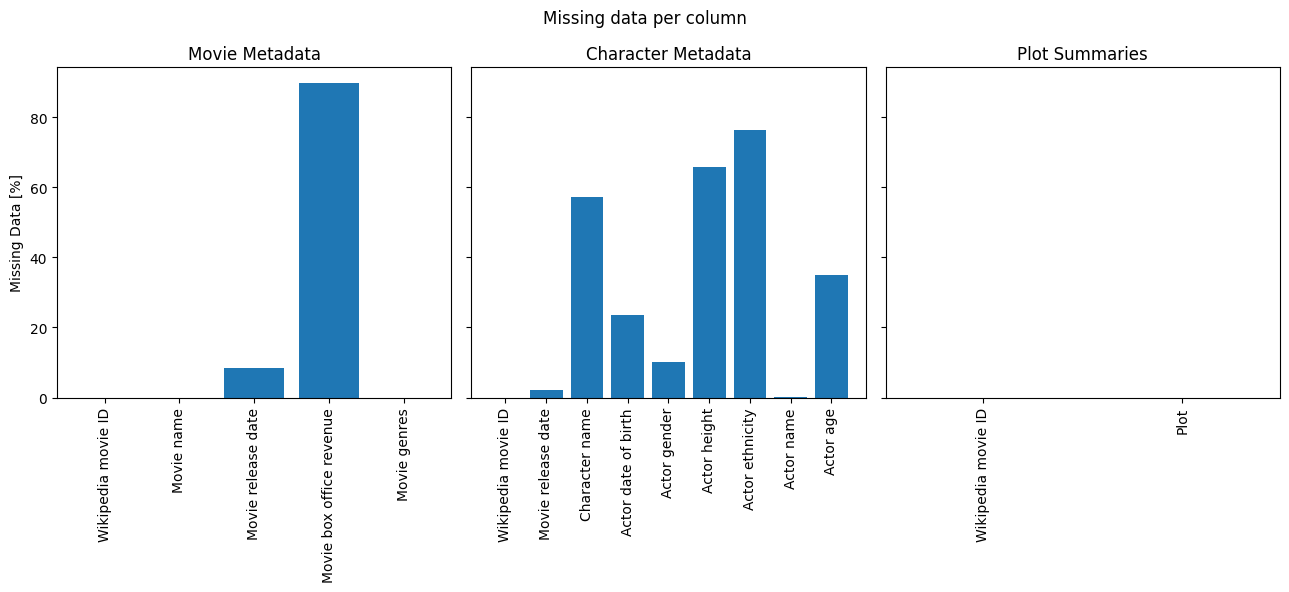

--- Dataset shapes ---
Movies metadata: (81741, 5)
Character metadata: (81741, 5)
Plot summaries: (42303, 2)


In [8]:
# Calculating missing data
missing_movie = meta_movie.isnull().sum() * 100 / len(meta_movie)
missing_char = meta_charac.isnull().sum() * 100 / len(meta_charac)
missing_plot = plot.isnull().sum() * 100 / len(plot)

#Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 6), sharey=True)
fig.suptitle('Missing data per column')

ax1.set(ylabel= 'Missing Data [%]')
ax1.bar(missing_movie.index, missing_movie.values)
ax1.tick_params(axis='x', labelrotation = 90)
ax1.set_title("Movie Metadata")
ax2.bar(missing_char.index, missing_char.values)
ax2.tick_params(axis='x', labelrotation = 90)
ax2.set_title("Character Metadata")
ax3.bar(missing_plot.index, missing_plot.values)
ax3.tick_params(axis='x', labelrotation = 90)
ax3.set_title("Plot Summaries")
plt.tight_layout()
plt.show()

print("--- Dataset shapes ---")
print("Movies metadata: {}" .format(meta_movie.shape))
print("Character metadata: {}" .format(meta_movie.shape))
print("Plot summaries: {}" .format(plot.shape))

*Observation:* From this initial analysis, it's evident that there is a significant amount of missing data.

*Action:* To address this, we've decided to drop certain actor features, specifically `character name` ,  `actor height`, `actor ethnicity`, and `actor age`, recognizing the high incidence of missing values in these columns. We are keeping `Movie box office revenue` but are aware that we will have to be careful not to use it as is in our analysis.


In [9]:
charac = meta_charac.drop(columns=['Character name','Actor ethnicity', 'Actor height', 'Actor age'])

# 1. Dataframe 1: movies
## 1.1 Adding IMDb scores
We will start by adding the IMDb scores to the movie dataset, we want every movie in our dataset to have a rating, so we will use an **inner merge** (default) on the **title** and **year**. 

But first will need to have a look at the IMDb dataset.

In [11]:
#takes 25s to run
print("     ----- Title data sample -----")
display(imdb_title.sample(5))
print("     ----- Raiting data overview -----")
display(imdb_raitings.sample(5))

     ----- Title data sample -----


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,genres
3544792,tt14717274,tvEpisode,Episode #1.287,Episode #1.287,0,\N,Drama
5094065,tt19800874,tvEpisode,Episode dated 23 July 2021,Episode dated 23 July 2021,1,2021,Adult
8223178,tt5299300,video,John Carter: Populating Mars,John Carter: Populating Mars,0,2012,Short
7405352,tt3441982,tvEpisode,Aflevering 337,Aflevering 337,0,2009,"Adventure,Drama,Family"
7295743,tt3189370,tvEpisode,Episode #1.3,Episode #1.3,0,\N,Adventure


     ----- Raiting data overview -----


,tconst,averageRating,numVotes
1224766,tt6487616,6.0,39
118945,tt0176107,6.5,24
42775,tt0064656,5.6,13
412094,tt0853066,8.5,92
627652,tt1332665,7.2,80


In [10]:
# TODO: Get a better merge (Primary/ original titles ...)

imdb_movieTitle = imdb_title[imdb_title['titleType'] == 'movie'].copy() #keep only movies
imdb_movieTitle = imdb_movieTitle[imdb_movieTitle['startYear'] != '\\N'].copy() #remove nan years
imdb_movieTitle['startYear'] = imdb_movieTitle['startYear'].astype(int) # turn year to int
imdb_names.rename(columns={'nconst':'IMDb_actor_ID'}, inplace=True) #rename actor id for ease of use

# Merging the datasets
movies = meta_movie\
            .merge(imdb_movieTitle[['originalTitle','startYear','tconst']], left_on= ['Movie name', 'Movie release date'], right_on= ['originalTitle','startYear'], how= 'inner')\
            .merge(imdb_raitings, how ='inner')
movies.rename(columns={"tconst":"IMDb_ID"}, inplace= True) #rename IMDb ID for ease of use

print("--- Movie dataset size ---")
print(movies.shape)

--- Movie dataset size ---
(35612, 10)


Now lets work on the **movie genres**, we can use the fact that they are a dictionary to have a look at their frequency

In [12]:
# N.B Takes 20s to run
def count_genres(dictionary):
    return pd.Series(list(dictionary.values())).value_counts()

# Apply the custom function to the column
genre_counts = movies['Movie genres'].apply(count_genres).fillna(0).sum()


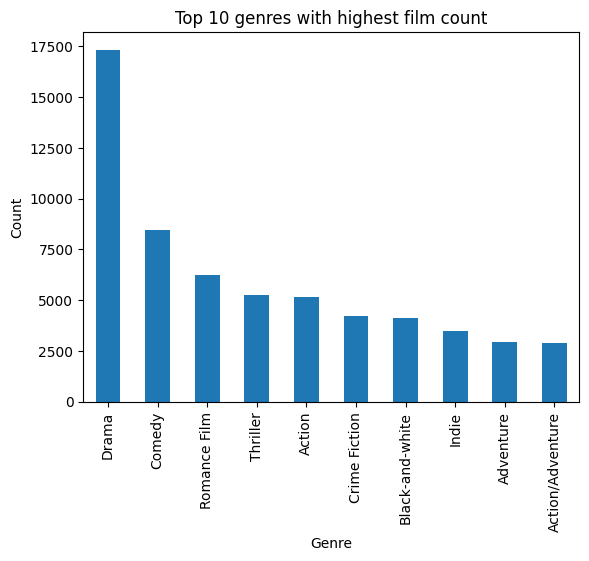

In [13]:
# Plot top 10 most represented genres
genre_counts = genre_counts.sort_values(ascending=False).head(10)
genre_counts.plot.bar()
plt.title("Top 10 genres with highest film count")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

*Observation:* Based on the graph, it is evident that drama movies are significantly more represented than other genres.

*Decision:* In light of this observation, we have decided to focus our analysis primarily on drama movies, considering their substantial representation in the dataset.

## 1.2 Filtering
We are proceeding to filter outliers in the dataset. The goal is to identify and exclude any data points that deviate significantly from the general pattern, ensuring that our analysis is not unduly influenced by extreme values.

In [ ]:
#Save an unfieltered version of movies
movies_uf = movies.copy()

# There are outliers in the film duration. We are removing them to standardise our data
max_movie_runtime = 200 #minutes
min_movie_runtime = 40 #minutes
movies = movies.query('`Movie runtime` <= @max_movie_runtime and `Movie runtime` >= @min_movie_runtime').copy()

# To ensure enough films are available per year, we are removing the older and newer years
max_movie_year = 2012
min_movie_year = 1930
movies = movies.query('`Movie release date` <= @max_movie_year and `Movie release date` >= @min_movie_year').copy()


# 2. Dataframe 2 : Actors
## 2.1 Extracting main characters from IMDb 


In [16]:
#***************
# Function: get_top_actors
# In: - movies -> movie dataset 
#     - imdb_principals -> IMDb dataset with principal actors
#     - top_n -> number of principal actors to extract (default 3) [int]
#
# Out: - movie_actors -> dataframe with all actors per film. Columns: IMDb_ID, actor, ordering
# ***************

def get_top_actors(movies, imdb_principals, top_n=3):
    # Filter the 'imdb_principals' DataFrame to include only rows where the category is 'actor' or 'actress'.
    imdb_principal_actors = imdb_principals.query('category == "actor" | category == "actress"')

    # Further filter the above DataFrame to include only those actors/actresses that appear in the 'movies' DataFrame (matched by 'IMDb_ID')
    # and are within the top 'top_n' ordering. 'ordering' likely refers to the importance or lead level of the actor in the movie.
    imdb_principal_actors_valid = imdb_principal_actors[(imdb_principal_actors["IMDb_ID"].isin(movies["IMDb_ID"].values.tolist())) & 
                                                        (imdb_principal_actors["ordering"] <= top_n)]

    # Initialize an empty list to store movie-actor pairings.
    movie_actors = []

    bar = progressbar.ProgressBar(maxval=len(movies["IMDb_ID"])).start()

    # Iterate over each movie ID in the 'movies' DataFrame.
    for idx, id in enumerate(movies["IMDb_ID"]):
         # For each movie, find corresponding actors from 'imdb_principal_actors_valid' and select 'ordering' and 'IMDb_actor_ID'.
        tmp = imdb_principal_actors_valid.loc[imdb_principal_actors_valid["IMDb_ID"] == id][["ordering", "IMDb_actor_ID"]]

        # Append each actor's information along with the movie ID to the 'movie_actors' list.
        for _, row in tmp.iterrows():
            movie_actors.append([id, row["IMDb_actor_ID"], row["ordering"]])
        bar.update(idx)

    # Convert the 'movie_actors' list into a DataFrame for easier handling and readability.
    movie_actors = pd.DataFrame(movie_actors, columns=['IMDb_ID', 'actor', 'ordering'])

    # Return the resulting DataFrame.
    return movie_actors

In [17]:
imdb_principals.rename(columns={'nconst':'IMDb_actor_ID'}, inplace=True)
imdb_principals.rename(columns={'tconst':'IMDb_ID'}, inplace=True)

movie_actors = get_top_actors(movies, imdb_principals)
movie_actors.head()

,IMDb_ID,actor,ordering
0,tt0228333,nm0000449,1
1,tt0228333,nm0001084,2
2,tt0228333,nm0000427,3
3,tt0094806,nm0471903,1
4,tt0094806,nm0435274,2


## 2.2 Creating a one-to-many relationship
We want a one-to-many relationship between movies and movie_actors, i.e for every movie_actor, there is **exactly** one movie (no NaNs)

In [20]:
# creation of the DF only with valid actors
movies = movies[movies["IMDb_ID"].isin(movie_actors["IMDb_ID"].unique().tolist())]

In [21]:
# TODO: @THEO -> Pourquoi on fait ca??

# # takes ~10 seconds
# actors = movie_actors.merge(movies[['Wikipedia movie ID', 'Movie name', 'Movie release date', 'IMDb_ID']], on='IMDb_ID')
# actors = actors.merge(imdb_names[['primaryName', 'IMDb_actor_ID']], left_on='actor', right_on='IMDb_actor_ID').drop('IMDb_actor_ID', axis=1)
actors = movie_actors

# Awards feature

As a specific actor feature, we want to use the number of awards won. To do this we use a kaggle dataset ([link](https://www.kaggle.com/datasets/unanimad/the-oscar-award/code)).


In [ ]:
kaggle_awards = pd.read_csv('./data/kaggle/the_oscar_award.csv', header=0)
display(kaggle_awards)

We should filter to keep only movies that are in our dataset

In [ ]:
kaggle_awards = kaggle_awards[kaggle_awards['name'].isin(actors['primaryName'].unique())]
kaggle_awards = kaggle_awards[kaggle_awards['film'].isin(movies['Movie name'].unique())]
kaggle_awards

In [ ]:
kaggle_nans = kaggle_awards.isnull().sum() * 100 / len(kaggle_awards)
kaggle_nans.plot(kind='bar')
plt.title('Percentage of missing data per column')
plt.xlabel('Column')
plt.ylabel('Percentage of missing data [%]')

As we can see, the dataset is mostly NaNs free.

Let's now define a function to get the number of awards won by a given actor up until a given year. For this feature we will only consider the number of awards that the actor won before the movie was released. Using this function we will be able to add a new column in our previous dataframe. 

The function allow counting both the amount of awards won but also the number of nominations

In [ ]:
def count_awards(actor_name, year, win):
    filtered = kaggle_awards.query("year_film < {} & winner == {} & name == \"{}\"".format(year, win, actor_name))
    return len(filtered)

In [ ]:
# Takes ~40 seconds
actors['awards'] = [count_awards(row['primaryName'], row['Movie release date'], True) for (index, row) in actors.iterrows()]


In [ ]:
actors

In [ ]:
actors.awards.unique()

# 99 Final Data Analysis 
Lets have a look at what our final database looks like

In [ ]:
# get unfiltered movies with IMDb scores -> We select that years  that will not be plotted withg the filtered data
movies_ufR = movies_uf.query('`Movie release date` >= @max_movie_year').copy()
movies_ufL = movies_uf.query('`Movie release date` <= @min_movie_year').copy()

# get filtered and unfiltered drama movies
drama_movies = movies[movies['Movie genres'].apply(lambda x: 'Drama' in x.values())]
drama_movies_ufR = movies_uf[movies_uf['Movie genres'].apply(lambda x: 'Drama' in x.values())].query('`Movie release date` >= @max_movie_year').copy()
drama_movies_ufL = movies_uf[movies_uf['Movie genres'].apply(lambda x: 'Drama' in x.values())].query('`Movie release date` <= @min_movie_year').copy()

#There is a movie with a typo in the original dataset, we can change this manually
meta_movie["Movie release date"][meta_movie["Movie release date"]==1010] = 2010

# Count all movies without merging with IMDb
all_movie_counts = meta_movie['Wikipedia movie ID'].groupby(meta_movie['Movie release date']).count()

# Count movies after merging with IMDb with and wothout filtering
movie_counts = movies['Wikipedia movie ID'].groupby(movies['Movie release date']).count()
movie_counts_ufL = movies_ufL['Wikipedia movie ID'].groupby(movies_ufL['Movie release date']).count()
movie_counts_ufR = movies_ufR['Wikipedia movie ID'].groupby(movies_ufR['Movie release date']).count()

# Count drama movies aafter merging with IMDb with and without filtering
drama_counts = drama_movies['Wikipedia movie ID'].groupby(drama_movies['Movie release date']).count()
drama_counts_ufL = drama_movies_ufL['Wikipedia movie ID'].groupby(drama_movies_ufL['Movie release date']).count()
drama_counts_ufR = drama_movies_ufR['Wikipedia movie ID'].groupby(drama_movies_ufR['Movie release date']).count()

#       ----- PLOT -----
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey= True)

# subplot 1: plot all movie counts
axes[0].set_title('Movie count per Year')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Year')
axes[0].plot(all_movie_counts.index, all_movie_counts.values, color= 'C0', label= 'All movies')
axes[0].plot(movie_counts.index, movie_counts.values, color= 'C1', label= 'All movies with IMDb scores - filtered')
axes[0].plot(movie_counts_ufL.index, movie_counts_ufL.values, color= 'C1', linestyle = '--',label= 'All movies with IMDb scores - unfiltered')
axes[0].plot(movie_counts_ufR.index, movie_counts_ufR.values, color= 'C1', linestyle = '--')
axes[0].plot(drama_counts.index, drama_counts.values, color = 'C2', label='Dramas with IMDb scores - filtered')
axes[0].plot(drama_counts_ufL.index, drama_counts_ufL.values, color ='C2', linestyle = '--', label='Dramas with IMDb scores - unfiltered')
axes[0].plot(drama_counts_ufR.index, drama_counts_ufR.values, color ='C2', linestyle = '--')
axes[0].legend(loc="upper left")

axes[1].set_title('Frequency of movie duration')
axes[1].set_xlabel('Movie duration [minutes]')
axes[1].hist(movies['Movie runtime'], bins = 100, color = 'C1', label= 'All movies with IMDb scores - filtered')
axes[1].hist(drama_movies['Movie runtime'], bins = 100, color = 'C2', label= 'Dramas with IMDb scores - filtered')
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

*Observation:* We have dramatically reduced the amount of films in our dataset, however the distribution of the drama movies is similar to the all movies with IMDb score in both `Release date` and `Film duration`. We still have close to 15'000 drama movies to base our analysis on.

In [ ]:
movies.describe()

In [ ]:
drama_movies.describe()